In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import time
import random
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
warnings.filterwarnings('ignore')

In [2]:
# 读取数据
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
train_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


<Axes: xlabel='Age', ylabel='Count'>

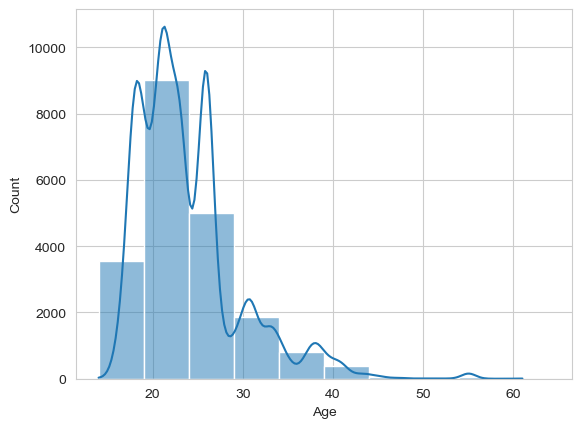

In [5]:
# 画年龄分布图
sns.histplot(data=train_df, x='Age', binwidth=5, kde=True)

In [3]:
# 计算BMI代替身高体重
bmi_train = train_df[["Weight", "Height"]].apply(lambda z: (z[0] / (z[1]) ** 2), axis=1)
bmi_test = test_df[["Weight", "Height"]].apply(lambda z: (z[0] / (z[1]) ** 2), axis=1)
train_df["BMI"] = bmi_train
test_df["BMI"] = bmi_test
train_df.drop(columns=['Weight', 'Height'], inplace=True)
test_df.drop(columns=['Weight', 'Height'], inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   family_history_with_overweight  20758 non-null  object 
 4   FAVC                            20758 non-null  object 
 5   FCVC                            20758 non-null  float64
 6   NCP                             20758 non-null  float64
 7   CAEC                            20758 non-null  object 
 8   SMOKE                           20758 non-null  object 
 9   CH2O                            20758 non-null  float64
 10  SCC                             20758 non-null  object 
 11  FAF                             20758 non-null  float64
 12  TUE                             

In [4]:
# 连续值特征标准化
continuous_features = train_df.select_dtypes(include=['float64']).columns.tolist()
for col in continuous_features:
    train_df[col] = (train_df[col] - train_df[col].mean()) / train_df[col].std()
    test_df[col] = (test_df[col] - test_df[col].mean()) / test_df[col].std()
train_df.head()

,id,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,Male,0.105696,yes,yes,-0.836259,0.314676,Sometimes,no,1.206565,no,-1.171113,0.597424,Sometimes,Public_Transportation,Overweight_Level_II,-0.237856
1,1,Female,-1.027027,yes,yes,-0.836259,0.338356,Frequently,no,-0.048348,no,0.021774,0.636498,no,Automobile,Normal_Weight,-0.818311
2,2,Female,-1.027027,yes,yes,-1.060306,-1.913377,Sometimes,no,-0.195640,no,-0.138019,1.755197,no,Public_Transportation,Insufficient_Weight,-1.573703
3,3,Female,-0.507917,yes,yes,1.039146,0.338356,Sometimes,no,-0.584021,no,0.579882,0.271448,Sometimes,Public_Transportation,Obesity_Type_III,1.753549
4,4,Male,1.371163,yes,yes,0.438386,-1.119774,Sometimes,no,-0.081467,no,1.176457,0.523099,Sometimes,Public_Transportation,Overweight_Level_II,-0.557083


In [5]:
# 定义离散变量连续值映射 
map_4 = {
    'Always': 1,
    'Frequently': 2 / 3,
    'Sometimes': 1 / 3,
    'no': 0
}
# 离散值连续化
feature_4 = ['CAEC', 'CALC']
for col in feature_4:
    train_df[col] = train_df[col].map(map_4)
    test_df[col] = test_df[col].map(map_4)
train_df.head()

,id,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,Male,0.105696,yes,yes,-0.836259,0.314676,0.333333,no,1.206565,no,-1.171113,0.597424,0.333333,Public_Transportation,Overweight_Level_II,-0.237856
1,1,Female,-1.027027,yes,yes,-0.836259,0.338356,0.666667,no,-0.048348,no,0.021774,0.636498,0.000000,Automobile,Normal_Weight,-0.818311
2,2,Female,-1.027027,yes,yes,-1.060306,-1.913377,0.333333,no,-0.195640,no,-0.138019,1.755197,0.000000,Public_Transportation,Insufficient_Weight,-1.573703
3,3,Female,-0.507917,yes,yes,1.039146,0.338356,0.333333,no,-0.584021,no,0.579882,0.271448,0.333333,Public_Transportation,Obesity_Type_III,1.753549
4,4,Male,1.371163,yes,yes,0.438386,-1.119774,0.333333,no,-0.081467,no,1.176457,0.523099,0.333333,Public_Transportation,Overweight_Level_II,-0.557083


In [6]:
# 离散值特征编码
encoder = OrdinalEncoder()
discrete_features = train_df.select_dtypes(include=['object']).columns.difference(['NObeyesdad']).tolist()
train_df[discrete_features] = encoder.fit_transform(train_df[discrete_features]).astype(int)
test_df[discrete_features] = encoder.fit_transform(test_df[discrete_features]).astype(int)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  int32  
 2   Age                             20758 non-null  float64
 3   family_history_with_overweight  20758 non-null  int32  
 4   FAVC                            20758 non-null  int32  
 5   FCVC                            20758 non-null  float64
 6   NCP                             20758 non-null  float64
 7   CAEC                            20758 non-null  float64
 8   SMOKE                           20758 non-null  int32  
 9   CH2O                            20758 non-null  float64
 10  SCC                             20758 non-null  int32  
 11  FAF                             20758 non-null  float64
 12  TUE                             

In [7]:
# 独热编码
train_df = pd.get_dummies(train_df, columns=['MTRANS'])
test_df = pd.get_dummies(test_df, columns=['MTRANS'])
bool_features = train_df.select_dtypes(include=['bool']).columns.tolist()
for col in bool_features:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  int32  
 2   Age                             20758 non-null  float64
 3   family_history_with_overweight  20758 non-null  int32  
 4   FAVC                            20758 non-null  int32  
 5   FCVC                            20758 non-null  float64
 6   NCP                             20758 non-null  float64
 7   CAEC                            20758 non-null  float64
 8   SMOKE                           20758 non-null  int32  
 9   CH2O                            20758 non-null  float64
 10  SCC                             20758 non-null  int32  
 11  FAF                             20758 non-null  float64
 12  TUE                             

<Axes: >

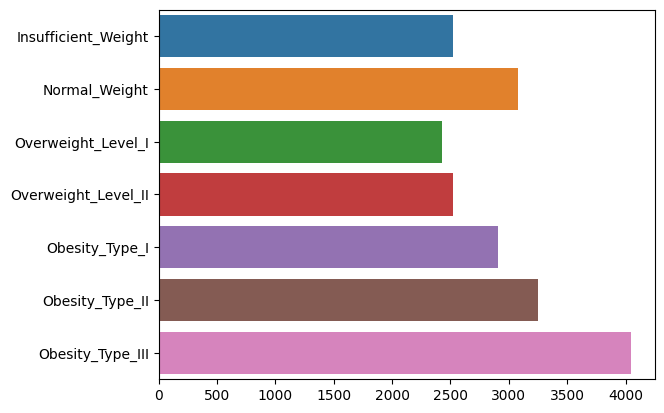

In [8]:
# 标签编码
target_label_map = {'Insufficient_Weight': 0,
                    'Normal_Weight': 1,
                    'Overweight_Level_I': 2,
                    'Overweight_Level_II': 3,
                    'Obesity_Type_I': 4,
                    'Obesity_Type_II': 5,
                    'Obesity_Type_III': 6
                    }
label_target_map = {0: 'Insufficient_Weight',
                    1: 'Normal_Weight',
                    2: 'Overweight_Level_I',
                    3: 'Overweight_Level_II',
                    4: 'Obesity_Type_I',
                    5: 'Obesity_Type_II',
                    6: 'Obesity_Type_III'
                    }
# y = train_df["NObeyesdad"]
# Counter(y)
train_df["NObeyesdad"] = train_df["NObeyesdad"].map(target_label_map)
# train_df.info()
y = {'Insufficient_Weight': 2523,
     'Normal_Weight': 3082,
     'Overweight_Level_I': 2427,
     'Overweight_Level_II': 2522,
     'Obesity_Type_I': 2910,
     'Obesity_Type_II': 3248,
     'Obesity_Type_III': 4046}
k = list(y.keys())
v = list(y.values())
sns.barplot(x=v, y=k)

In [9]:
# 选择特征
feature_cols = train_df.columns.difference(['id', 'NObeyesdad']).tolist()
# 划分训练集与测试集
train_x, test_x, train_y, test_y = train_test_split(train_df[feature_cols], train_df['NObeyesdad'], test_size=0.2)
train_x.head()

(16606, 19) (13840, 19)


array([[-0.63578809, -0.51527729,  0.33333333, ...,  0.        ,
         0.19016478,  1.        ],
       [ 0.49973868,  0.97034679,  0.33333333, ...,  0.        ,
        -0.89701069,  1.        ],
       [-1.02702717,  0.5733496 ,  0.33333333, ...,  0.        ,
        -1.02431892,  1.        ],
       ...,
       [ 0.66687352, -0.64800858,  0.33333333, ...,  0.        ,
        -0.42283761,  1.        ],
       [ 1.73888616, -0.16544904,  0.33333333, ...,  0.        ,
        -1.02431892,  1.        ],
       [-0.67541417,  0.34607583,  0.33333333, ...,  0.        ,
         0.63649759,  1.        ]])

In [ ]:
# df转为ndarray
train_x, test_x, train_y, test_y = train_x.values, test_x.values, train_y.values, test_y.values
data = test_df[feature_cols].values
print(train_x.shape, data.shape)
# test_df.info()
# train_df.info()
train_x

In [94]:
# 模型一：对数几率回归
class MyLogRegClf:
    """
    自定义逻辑回归分类器，采用随机梯度下降法进行训练

    参数:
    ------
    max_iters : int, 默认=200
        模型训练的最大迭代次数
    learning_rate : float, 默认=0.01
        学习率，控制每次参数更新的步长
    batch_size : int, 默认=1000
        每次更新权重时使用的样本数量

    方法:
    ------
    add_bias(X)
        在输入数据集X中添加一列全1值作为偏置项
    softmax(d)
        应用softmax函数将向量转换为概率分布
    fit(X, y)
        使用随机梯度下降法训练模型
    predict(X)
        根据训练好的模型对新数据进行预测
    score(X, y)
        计算模型在给定数据上的预测准确率
    """
     
    def __init__(self, max_iters=200, learning_rate=0.01, batch_size=1000):
        self.max_iters = max_iters  # 最大迭代次数
        self.learning_rate = learning_rate  # 学习率
        self.batch_size = batch_size
        
    def add_bias(self, X):  
        """在数据集中增加一个偏置项，即增加一个全1列"""
        return np.insert(X, 0, np.ones(len(X)), axis=1)

    def softmax(self, d):
        """应用softmax函数将向量转换为概率分布"""
        return np.exp(d) / np.sum(np.exp(d))
        
    def fit(self, X, y):
        """使用随机梯度下降法训练模型"""
        X = self.add_bias(X)
        self.weights = np.zeros((len(X[0]), 7), dtype=np.float32)
        for step_ in range(self.max_iters):
            # if step_ % 50 == 0:
                # print("round {}\nscore {}".format(step_, self.score(test_x, test_y)))
                # print("*********************************************************")
            for j in range(self.batch_size):
                i = random.randint(0, len(X) - 1)
                pre = self.softmax(np.dot(X[i], self.weights))
                obj = np.eye(7)[int(y[i])]  # 将标签值变成独热向量, 如[5] 变成 [0 0 0 0 0 1 0]
                err = pre - obj
                self.weights -= self.learning_rate * np.transpose([X[i]]) * err
            
    def predict(self, X):
        """根据训练好的模型对新数据进行预测"""
        X = self.add_bias(X)
        return np.argmax(self.softmax(np.dot(X, self.weights)), axis=1)

    def score(self, X, y):
        """计算模型在给定数据上的预测准确率"""
        X = self.add_bias(X)
        right = 0
        for i in range(len(X)):
            pre = np.dot(X[i], self.weights)
            pre2 = np.argmax(self.softmax(pre))  # 找到softmax(pre)向量中值最大对应的索引，也就是预测的类别
            if pre2 == y[i]:  # 索引跟真实值一样，说明预测正确
                right += 1
        return right / len(X)

In [39]:
# 对数几率回归训练与测试
logreg = MyLogRegClf(learning_rate=0.01, max_iters=500, batch_size=1000)
start = time.time()
logreg.fit(train_x, train_y)
end = time.time()
print(f'训练用时：{(end - start):.1f}s')
train_pred = logreg.predict(train_x)
test_pred = logreg.predict(test_x)
train_accu = metrics.accuracy_score(train_y, train_pred)
test_accu = metrics.accuracy_score(test_y, test_pred)
test_f1 = metrics.f1_score(test_y, test_pred, average='macro')
print(f'准确率: {test_accu:.4f}\nF1 score: {test_f1:.4f}')

训练用时：6.5s
准确率: 0.8276
F1 score: 0.8090


In [1]:
plt.style.use('seaborn-white')
disp = metrics.ConfusionMatrixDisplay.from_predictions(test_y, test_pred)
# disp.figure_.suptitle("Confusion Matrix")

disp.figure_.savefig("confusion_matrix.png")

NameError: name 'plt' is not defined

In [96]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=500)
start = time.time()
logreg.fit(train_x, train_y)
end = time.time()
print(f'训练用时：{(end - start):.1f}s')
test_pred = logreg.predict(test_x)
test_accu = metrics.accuracy_score(test_y, test_pred)
test_f1 = metrics.f1_score(test_y, test_pred, average='macro')
print(f'准确率: {test_accu:.4f}\nF1 score: {test_f1:.4f}')

训练用时：1.7s
准确率: 0.8471
F1 score: 0.8300


<Axes: >

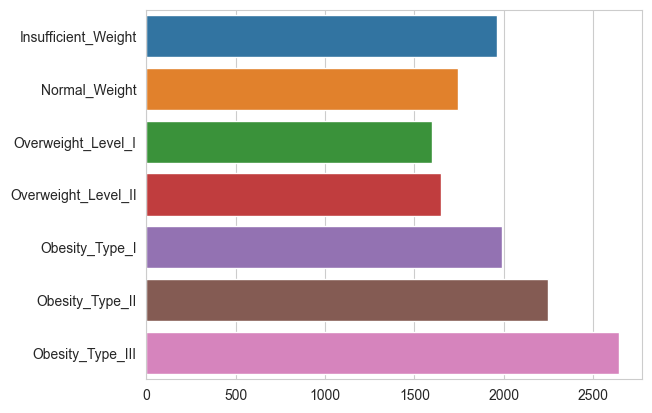

In [23]:
ans_nd = logreg.predict(data)
# ans_nd = ans_nd.map(labelTargetMap)
ans_df = pd.DataFrame(data=ans_nd, columns=['NObeyesdad'])
ans_df['NObeyesdad'] = ans_df['NObeyesdad'].map(label_target_map)
ss = pd.read_csv('softmax.csv')
ss['NObeyesdad'] = ans_df['NObeyesdad']
ss.to_csv('softmax.csv', index=False)
# ans_df.to_csv('sscopy.csv', mode='w', columns=['NObeyesdad'])
# ans_df.to_csv('sample_submission.csv', mode='a', columns=['NObeyesdad'])
# Counter(ans_nd)
cnt = {0:1963, 1: 1746, 2: 1601, 3: 1651, 4: 1988, 5: 2248, 6: 2643}
new_cnt = {label_target_map[k]: v for k, v in cnt.items()}
k = list(new_cnt.keys())
v = list(new_cnt.values())
sns.barplot(x=v, y=k)

In [24]:
# 模型三：决策树
class MyDecisionTreeClf:
    """
    自定义决策树分类器，基于信息熵和最佳分割点选择策略

    参数:
    ------
    max_depth : int, 默认=5
        决策树的最大深度，防止过拟合

    方法:
    ------
    fit(X, y)
        基于给定的特征和标签训练决策树模型
    predict(X)
        使用训练好的决策树对新数据进行预测
    accuracy(y_pred, y_test)
        计算模型在测试集上的预测准确率
    """

    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        """
        训练决策树模型

        参数:
        ------
        X : numpy.ndarray
            特征矩阵，二维数组
        y : numpy.ndarray
            标签向量，一维数组

        内部方法:
        ---------
        calc_entropy(y)
            计算给定标签集合的信息熵
        split_data(X, y, feature, thres)
            根据特征和阈值分割数据
        find_best_split(X, y)
            寻找最佳分割特征和阈值，以最大化信息增益
        build_tree(X, y, depth=0)
            递归构建决策树
        """

        def calc_entropy(y):
            h = np.bincount(y)
            ps = h / len(y)
            return -np.sum([p * np.log2(p) for p in ps if p > 0])

        def split_data(X, y, feature, thres):
            return X[X[:, feature] <= thres], X[X[:, feature] > thres], y[X[:, feature] <= thres], y[X[:, feature] > thres]

        def find_best_split(X, y):
            best_gain = float('-inf')
            best_feature = None
            best_threshold = None

            # 遍历所有特征
            for feature in range(X.shape[1]):
                # 对特征取值去重
                unique_vals = np.unique(X[:, feature])
                # 遍历特征取值
                for thres in unique_vals:
                    # 以每个取值为阈值，尝试分割
                    X_left, X_right, y_left, y_right = split_data(X, y, feature, thres)

                    if len(y_left) == 0 or len(y_right) == 0:
                        continue

                    # 计算信息增益
                    gain = calc_entropy(y) - (len(y_left) / len(y)) * calc_entropy(y_left) - (len(y_right) / len(y)) * calc_entropy(y_right)
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = thres

            return best_gain, best_feature, best_threshold

        def build_tree(X, y, depth=0):
            if len(y) == 0 or (self.max_depth is not None and depth >= self.max_depth):
                return Counter(y).most_common(1)[0][0]  # 返回最常见的类别作为叶子节点  

            gain, feature, thres = find_best_split(X, y)

            if gain <= 0:
                return Counter(y).most_common(1)[0][0]  # 如果没有增益，返回最常见的类别  

            X_left, X_right, y_left, y_right = split_data(X, y, feature, thres)

            left = build_tree(X_left, y_left, depth + 1)
            right = build_tree(X_right, y_right, depth + 1)

            return {'feature': feature, 'threshold': thres, 'left': left, 'right': right}

        self.tree = build_tree(X, y)

    def predict(self, X):
        """
        预测新数据的类别

        参数:
        ------
        X : numpy.ndarray
            新数据的特征矩阵，二维数组

        返回:
        ------
        y_pred : numpy.ndarray
            预测结果，与X同形状的一维数组
        """

        def traverse_tree(node, sample):
            if isinstance(node, dict):
                if sample[node['feature']] <= node['threshold']:
                    return traverse_tree(node['left'], sample)
                else:
                    return traverse_tree(node['right'], sample)
            else:
                return node

        return np.array([traverse_tree(self.tree, sample) for sample in X])

    def accuracy(self, y_pred, y_test):
        """
        计算模型在测试集上的预测准确率

        参数:
        ------
        y_pred : numpy.ndarray
            模型预测的标签向量
        y_test : numpy.ndarray
            测试集的真实标签向量

        返回:
        ------
        acc : float
            准确率，范围在0到1之间
        """
        acc = sum(np.equal(y_pred, y_test) / len(y_pred))
        return acc

In [17]:
dt = MyDecisionTreeClf(max_depth=4)
start = time.time()
dt.fit(train_x, train_y)
end = time.time()
print(f'训练用时：{(end - start):.1f}s')
train_pred = dt.predict(train_x)
test_pred = dt.predict(test_x)
train_accu = metrics.accuracy_score(train_y, train_pred)
test_accu = metrics.accuracy_score(test_y, test_pred)
test_f1 = metrics.f1_score(test_y, test_pred, average='macro')
print(f'准确率: {test_accu:.4f}\nF1 score: {test_f1:.4f}')

训练用时：51.2s
准确率: 0.8444
F1 score: 0.8238


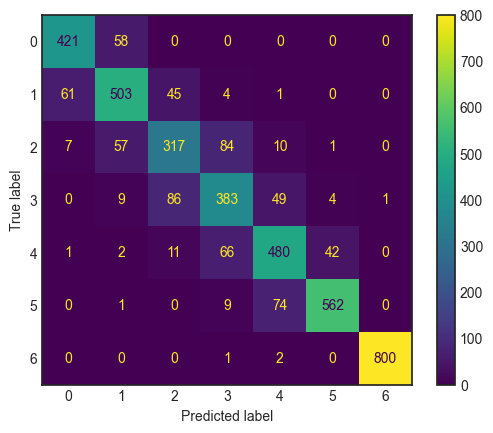

In [57]:
plt.style.use('seaborn-white')
disp = metrics.ConfusionMatrixDisplay.from_predictions(test_y, test_pred)
# disp.figure_.suptitle("Confusion Matrix")

disp.figure_.savefig("confusion_matrix.png")

In [38]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=4, criterion='entropy')
start = time.time()
dt.fit(train_x, train_y)
end = time.time()
print(f'训练用时：{(end - start):.1f}s')
test_pred = dt.predict(test_x)
test_accu = metrics.accuracy_score(test_y, test_pred)
test_f1 = metrics.f1_score(test_y, test_pred, average='macro')
print(f'准确率: {test_accu:.4f}\nF1 score: {test_f1:.4f}')

训练用时：0.0s
准确率: 0.8350
F1 score: 0.8212


In [82]:
ans_nd = dt.predict(data)
# ans_nd = ans_nd.map(labelTargetMap)
ans_df = pd.DataFrame(data=ans_nd, columns=['NObeyesdad'])
ans_df['NObeyesdad'] = ans_df['NObeyesdad'].map(label_target_map)
ss = pd.read_csv('dectree.csv')
ss['NObeyesdad'] = ans_df['NObeyesdad']
ss.to_csv('dectree.csv', index=False)
# ans_df.to_csv('sscopy.csv', mode='w', columns=['NObeyesdad'])
# ans_df.to_csv('sample_submission.csv', mode='a', columns=['NObeyesdad'])

In [26]:
# 模型二：KDTree
class Node:
    """
    K-d树中的节点类，包含节点值、左子节点和右子节点

    参数:
    ------
    data : list/tuple
        节点的k维数据
    left : Node, 可选，默认=None
        左子节点
    right : Node, 可选，默认=None
        右子节点
    """
    
    def __init__(self, data, left=None, right=None) -> None:
        self.val = data
        self.left = left
        self.right = right


class MyKdTreeClf:
    """
    自定义K-d树分类器，用于k维空间的最近邻搜索

    参数:
    ------
    k : int
        数据的维度数

    方法:
    ------
    create_Tree(dataset, depth)
        从数据集中构建K-d树
    search(tree, new_data)
        在K-d树中搜索与new_data最近的点
    distance(point_1, point_2)
        计算两个k维点之间的欧氏距离
    """
    
    def __init__(self, k) -> None:
        self.k = k

    def create_Tree(self, dataset, depth):
        """
        从给定的数据集构建K-d树

        参数:
        ------
        dataset : list of lists/tuples
            k维数据集，每个元素表示一个k维点
        depth : int
            当前构建的节点在树中的深度

        返回:
        ------
        Node
            构建的K-d树根节点
        """
        if not dataset:
            return None
        mid_index = len(dataset) // 2  # 中位数
        axis = depth % self.k  # 计算按照哪个坐标轴划分，由于索引从0开始，无需+1
        sort_dataset = sorted(dataset, key=(lambda x: x[axis]))  # 按照坐标轴划分
        mid_data = sort_dataset[mid_index]  # 中位数数据
        cur_node = Node(mid_data)  # 创建当前节点
        left_data = sort_dataset[:mid_index]  # 划分左右节点数据
        right_data = sort_dataset[mid_index + 1:]
        cur_node.left = self.create_Tree(left_data, depth + 1)
        cur_node.right = self.create_Tree(right_data, depth + 1)
        return cur_node

    def search(self, tree, new_data):
        """
        在K-d树中搜索与new_data最近的点

        参数:
        ------
        tree : Node
            K-d树的根节点
        new_data : list/tuple
            目标点的k维数据

        返回:
        ------
        list/tuple
            最近邻点的k维数据
        """
        self.near_point = None  # 当前最邻近点
        self.near_val = None  # 当前最邻近点与目标节点之间的距离

        def dfs(node, depth):
            # 递归找叶子结点
            if not node:
                return
            axis = depth % self.k
            if new_data[axis] < node.val[axis]:
                dfs(node.left, depth + 1)
            else:
                dfs(node.right, depth + 1)

            # 比较距离，判断是否更新最邻近点
            dist = self.distance(new_data, node.val)
            if not self.near_val or dist < self.near_val:
                self.near_val = dist
                self.near_point = node.val

            # 向上回退的时候判断是否需要进入另一个子节点寻找
            if abs(new_data[axis] - node.val[axis]) <= self.near_val:  
                # 计算父节点在其分割特征上的值距离目标点在该特征上的值的距离，若该距离小于当前的最小距离，则进入另一个子节点，否则不进入
                # 之前在左边找的现在去右边找，之前在右边找的现在去左边找
                if new_data[axis] < node.val[axis]:  
                    dfs(node.right, depth + 1)
                else:
                    dfs(node.left, depth + 1)

        dfs(tree, 0)
        return self.near_point

    def distance(self, point_1, point_2):
        """
        计算两个k维点之间的欧氏距离

        参数:
        ------
        point_1 : list/tuple
            第一个k维点
        point_2 : list/tuple
            第二个k维点

        返回:
        ------
        float
            欧氏距离
        """
        res = 0
        for i in range(self.k):
            res += (point_1[i] - point_2[i]) ** 2
        return res ** 0.5


In [54]:
# x = np.array([[2, 3], [5, 4], [9, 6], [4, 7], [8, 1], [7, 2]])
train_x_list = train_x.tolist()
# y = np.array([1, 1, 2, 1, 2, 2])
train_y_list = train_y.tolist()
# test = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]])
test_x_list = test_x.tolist()
pred = []
# new_data = [1, 5]
k = len(train_x_list[0])
kd_tree = MyKdTreeClf(k)
start = time.time()
our_tree = kd_tree.create_Tree(train_x_list, 0)
end = time.time()
print(f'训练用时：{(end - start):.1f}s')
start = time.time()
for test in test_x_list:
    predict = kd_tree.search(our_tree, test)
    pred.append(train_y_list[train_x_list.index(predict)])
end = time.time()
print(f'预测用时：{(end - start):.1f}s')
test_pred = np.array(pred).T
test_accu = metrics.accuracy_score(test_y, test_pred)
test_f1 = metrics.f1_score(test_y, test_pred, average='macro')
print(f'准确率: {test_accu:.4f}\nF1 score: {test_f1:.4f}')

训练用时：0.1s
预测用时：31.3s
准确率: 0.7416
F1 score: 0.7177


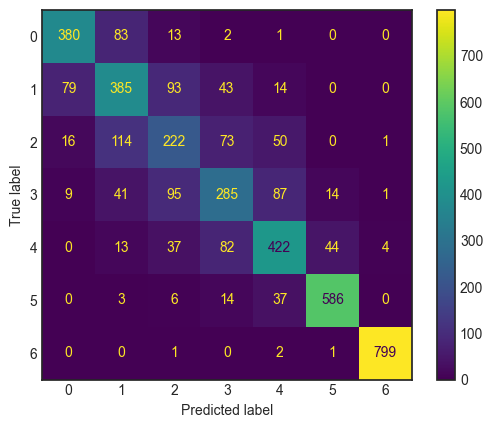

In [55]:
plt.style.use('seaborn-white')
disp = metrics.ConfusionMatrixDisplay.from_predictions(test_y, test_pred)
# disp.figure_.suptitle("Confusion Matrix")

disp.figure_.savefig("confusion_matrix.png")

In [98]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
start = time.time()
knn.fit(train_x, train_y)
end = time.time()
print(f'训练用时：{(end - start):.1f}s')
start = time.time()
pred = knn.predict(test_x)
end = time.time()
print(f'预测用时：{(end - start):.1f}s')
test_accu = metrics.accuracy_score(test_y, pred)
test_f1 = metrics.f1_score(test_y, pred, average='macro')
print(f'准确率: {test_accu:.4f}\nF1 score: {test_f1:.4f}')

训练用时：0.1s
预测用时：0.7s
准确率: 0.7599
F1 score: 0.7336


In [28]:
# value = [0.8372 * 100, 0.8177 * 100, 18.9, 0.7486 * 100, 0.7232 * 100, 46.6, 0.8410 * 100, 0.8268 * 100, 51.4]
value = [0.8372, 0.8177, 0.7486, 0.7232, 0.8410, 0.8268]
model = ['SoftMax', 'SoftMax', 'KdTree', 'KdTree', 'DecTree', 'DecTree']
metrics = ['Accuracy', 'F1 score', 'Accuracy', 'F1 score', 'Accuracy', 'F1 score']
time = [18.9, 46.6, 51.4]
model_time = ['SoftMax', 'KdTree', 'DecTree']
metrics_time = ['Time', 'Time', 'Time']
fin = pd.DataFrame({'model': model, 'value': value, 'metrics': metrics})
tin = pd.DataFrame({'model': model_time, 'value': time, 'metrics': metrics_time})
fin

,model,value,metrics
0,SoftMax,0.8372,Accuracy
1,SoftMax,0.8177,F1 score
2,KdTree,0.7486,Accuracy
3,KdTree,0.7232,F1 score
4,DecTree,0.8410,Accuracy
5,DecTree,0.8268,F1 score


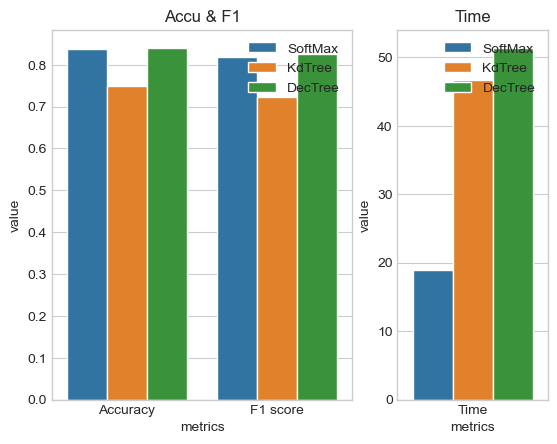

In [29]:
plt.style.use('seaborn-v0_8-whitegrid')
gs = gridspec.GridSpec(1, 2, width_ratios=[6, 3], hspace=0.2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
fig1 = sns.barplot(x='metrics', y="value", hue="model", data=fin, ax=ax1)
fig1.legend(loc='upper right')
fig1.set_title('Accu & F1')
fig2 = sns.barplot(x='metrics', y="value", hue="model", data=tin, ax=ax2)
fig2.set_title('Time')
fig2.legend(loc='upper right')